# Collaborative Review Task 4

## Case Study

In this assignment, you are going to be required to price a European put option using the three different techniques introduced in this module. The parameters are as follows:

- Risk-free continuously-compounded interest rate, r, of 10%
- Strike price, $ K $, of $1000

- Initial stock price, $ S_0 $, of $120

- Time to maturity, $ T $, of 2 years
- Stock volatility, $ \sigma $, of 25%

You may make all the assumptions of the standard Black-Scholes model.

1. Initialize the relevant parameters.

2. Calculate the analytical price for the put option using the closed-form solution.

3. Calculate the estimate for the put price using the characteristic function and technique described in note set 1. Use a maximum integral bound of 40 and $ N = 200 $ rectangles to approximate your integral. 

4. Observe that the payoff of a put option for the variable $ S_T = \log(\frac{S_T}{K})$ is $ p(s) = K(1-e^s)_{s<=0} $. This means that our $ v_n $ co-efficients in the COS method become:

    $ v_n = \frac{2}{b_2-b_1} \int_{b_1}^0 K(1-e^s) \cos(n \pi \frac{s-a}{b-a}) 
    = \frac{2}{b_2-b_1} K(\psi_n(b_1,0)-\theta_n(b_1,0)))$
    
    Using this information, use the COS method to price an European put option using the given parameters. Calculate put prices for increasing upper limits on the COS method sum. Plot your results against the analytical put price.

5. Use the fast Fourier transform (FFT) to price an European put option with the given parameters. You will have to price your put option for a range of strikes. Note that the only difference when applying the FFT to a put, when compared to a call, is that your value for $ \alpha $ must be less than -1. Use a sequence length for your $ x_n $ of $ N = 2^10 $, and use $ \delta_u = 0.25 $. Plot the estimated put prices against the analytical put prices (across the range of strikes).

## Answer

### Import Python library

In [1]:
import numpy as np
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

#### 1. Initialize the relevant parameters.

In [2]:
# Share specfic information
r = 0.1
S0 = 120
sigma = 0.25

# Put Option Specific Information
K = 1000
T = 2
k_log = np.log(K)

#### 2. Calculate the analytical price for the put option using the closed form solution

In [3]:
# 3 functions to calculate d_1,d_2, and analytical put price

def d_1_calculate(S_0,K,r,sigma,T):
    """Function for d_1 calculation"""
    a = math.log(S_0/K)
    b = (r + (sigma**2 / 2)) * T
    c = sigma * math.sqrt(T)
    result = (a + b) / c
    return result

def d_2_calculate(d_1,sigma,T):
    a = sigma * math.sqrt(T)
    result = d_1 - a
    return result

# Function for Analytical Solution
def analytic_putprice_calculate(S_0,d_1,d_2,K,r,T):
    a = -S_0 * norm.cdf(-d_1)
    b = norm.cdf(-d_2) * K * math.exp(-r * T)
    result = a + b
    return result

In [4]:
d_1 = d_1_calculate(S0,K,r,sigma,T)
d_2 = d_2_calculate(d_1,sigma,T)

analytic_putprice = analytic_putprice_calculate(S0,d_1,d_2,K,r,T)
print("The Analytical price for the Put Option is: {}".format(analytic_putprice))

The Analytical price for the Put Option is: 698.7307536073846


#### 3. Calculate the estimate for the put price using the characteristic function

In [5]:
# Characteristic functions
def c_M1(t):
    #a = np.log(S0) + (r - sigma**2/2)*T
    #b = (1/2) * (sigma**2) * T * (t**2)
    #result = np.exp(1j*a - b)
    #return result
    return np.exp(1j*t*(np.log(S0)+(r-sigma**2/2)*T)-1/2*(sigma**2)*T*(t**2))



def c_M2(t):
    #a = 1j * sigma**2 * T
    #result = np.exp(a) * c_M1(t)
    #return result
    return np.exp(1j*t*(sigma**2)*T)*c_M1(t)

In [6]:
# Choosing t_max and N
t_max = 20
N = 200

# Calculating delta and constructing t_n
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

In [7]:
# Appriximate integral estimates

# Function calculate integral
#def degree_integral(t_n,k_log,c_M_degree_diff,delta_t):
    #a = np.exp(-1j*t_n*k_log)
    #b = (a * c_M_degree_diff).imag
    #c = b/t_n * delta_t
    #result = sum(c)
    #return result
    #result = sum(((( np.exp(-1j*t_n*k_log)*c_M_degree_diff(t_n)).imag)/t_n)*delta_t)
    #return result

first_integral = sum((((np.exp(-1j*t_n*k_log)*c_M2(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*c_M1(t_n)).imag)/t_n)*delta_t)

In [8]:
# Calculate Fourier call price
def Fourier_call_price(S0, first_integral,r,T,K,second_integral):
    a = S0*(1/2 + first_integral/np.pi)
    b = np.exp(-r*T) * K
    c = b * (1/2 + (second_integral)/np.pi)
    result = a - c
    return result

fourier_call_val = Fourier_call_price(S0,first_integral,r,T,K,second_integral)
fourier_call_val

5.293757733766616e-07

In [9]:
# Calculate Fourier put price
def Fourier_put_price(S0, fourier_call_val,K,r,T):
    a = K * np.exp(-r*T)
    result = a + fourier_call_val - S0
    return result
fourier_put_val = Fourier_put_price(S0,fourier_call_val,K,r,T)
print('The Fourier Estimation for the Put Option is: {}'.format(fourier_put_val))

The Fourier Estimation for the Put Option is: 698.7307536073577


#### 4. Use the COS method to price an European put option using the given parameters. Calculate put prices for increasing upper limits on the COS method sum. Plot your results against the analytical put price. 

Using the Fourier-Cosine Method:

In [10]:
# General functions for valuations:
def upsilon_n(b1,b2,d,c,n):
        npi_d = np.pi*n*(d-b1) / (b2-b1)
        npi_c = np.pi*n*(c-b1) / (b2-b1)
        val_one = (np.cos(npi_d)*np.exp(d) - np.cos(npi_c)*np.exp(c))
        val_two = (n*np.pi*(np.sin(npi_d)*np.exp(d) - np.sin(npi_c)*np.exp(c))/ (b2-b1))
        return (val_one + val_two ) / ( 1+(n*np.pi/(b2-b1))**2)

def psi_n(b1,b2,d,c,n):
    if n == 0:
        return d-c 
    else:
        return (b2-b1)*(np.sin(n*np.pi*(d-b1)/(b2-b1)) - np.sin(n*np.pi*(c-b1)/(b2-b1)))/(n*np.pi)

In [11]:
# Functions for put valuation (similar to call function)
def v_n(K,b1,b2,n):
    return 2*K*(upsilon_n(b2,b1,b2,0,n) -  psi_n(b2,b1,b2,0,n))/(b1-b2)

def logchar_func(u,S0,r,sigma,K,T):
    return np.exp(1j*u*(np.log(S0/K)+(r-sigma**2/2)*T) - (sigma**2)*T*(u**2)/2)

def put_price(N,S0,sigma,r,K,T,b2,b1):
    price = v_n(K,b2,b1,0)*logchar_func(0,S0,r,sigma,K,T)/2
    for n in range(1,N):
        price = price + logchar_func(n*np.pi/(b2-b1),S0,r,sigma,K,T)*np.exp(-1j*n*np.pi*b1/(b2-b1))*v_n(K,b2,b1,n)
    return price.real*np.exp(-r*T)

In [12]:
#b1, b2 for call
c1 = r
c2 = T*sigma**2
c4 = 0
L = 10

b1 = c1 - L*np.sqrt(c2-np.sqrt(c4))
b2 = c1 + L*np.sqrt(c2-np.sqrt(c4))

In [13]:
# Calculating COS for various N
COS_putprice = [None]*50

for i in range(1,51):
    COS_putprice[i-1] = put_price(i,S0,sigma,r,K,T,b2,b1)

print('The fourier estimation of Put Option using COS is: {}'.format(COS_putprice[-1]))

The fourier estimation of Put Option using COS is: 698.7306714474088


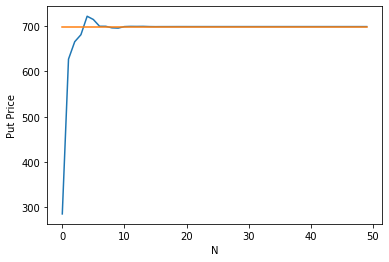

In [14]:
# Plotting the results
plt.plot(COS_putprice)
plt.plot([analytic_putprice]*50)
plt.xlabel("N")
plt.ylabel("Put Price")
plt.show()

#### 5. Use the fast Fourier transform (FFT) to price an European put option with the given parameters

In [31]:
# Algorith info
N = 2**10
delta = 0.25
alpha = -5

In [39]:
def log_char(u):
    return np.exp(1j*u*(np.log(S0)+(r-sigma**2/2)*T)-sigma**2*T*u**2/2)

def c_func(v):
    val1 = np.exp(-r*T)*log_char(v-(alpha+1)*1j)
    val2 = alpha**2+alpha-v**2+1j*(2*alpha+1)*v
    return val1/val2

In [40]:
n = np.array(range(N))
delta_k = 2*np.pi/(N*delta)
b = delta_k*(N-1)/2

log_strike = np.linspace(-b,b,N)

In [41]:
x = np.exp(1j*b*n*delta)*c_func(n*delta)*delta
x[0] = x[0]*0.5
x[-1] = x[-1]*0.5

xhat = np.fft.fft(x).real

fft_put = np.exp(-alpha*log_strike)*xhat/np.pi
fft_put[-1]

231603.0420958179

In [42]:
len(fft_put)

1024

In [47]:
analytic_putprice = -S0*norm.cdf(-d_1)+np.exp(log_strike)*np.exp(-r*T)*norm.cdf(-d_2)

In [48]:
len(analytic_putprice)

1024

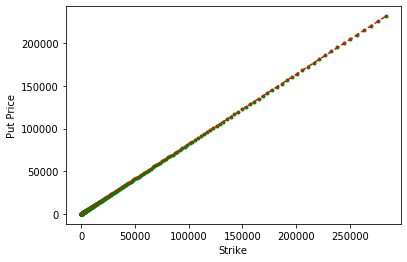

In [49]:
plt.plot(np.exp(log_strike), analytic_putprice,'g.') 
plt.plot(np.exp(log_strike), fft_put,'r--') 
plt.xlabel("Strike")
plt.ylabel("Put Price")
plt.show()